# Is there hope for interest rates in foreign exchange market? UIP, Carry Trade and Artificial Intelligence.

Celem artykułu jest sprawdzenie, czy istnieje strategia oparta jedynie na modelowaniu kursu walutowego za pomocą stóp procentowych, mogąca dawać stabilne, pozytywne wyniki. Strategia oparta na wskazaniach modelu: 
+ model wskazuje wyższy kurs w przewidywanym okresie - zajmujemy pozycję długą na parze USDPLN (pożyczamy PLN po stopie WIBOR, kupujemy USD, lokujemy je w USD T-Bill, na koniec wymienamy na PLN)
+ model wskazuje niższy kurs w przewidywanym okresie - zajmujemy pozycję krótką na parze USDPLN (pożyczamy USD po stopie LIBOR USD, kupujemy PLN, lokujemy je po stopie WIBID, na koniec wymienamy na USD)

Okres, na którym przeprowadzamy badania obejmuje czas od początku roku 2000, do sierpnia 2018 roku. Ten okres dzielimy na 2 podokresy:
+ okres treningowy - od 01.2000 do  07.2014 - na którym 'trenujemy' nasz model (zarówno OLS, jak i RNN).
+ okres testowy - od 07.2014 do 08.2018 - na którym testujemy wyniki otrzymane na okresie treningowym.

Plan artykułu wygląda następująco:
1. Wprowadzenie do tematu kursów walutowych i stop procentowej - odniesienie się do UIP, oraz strategii Carry Trade.
2. Opis danych wykorzystanych do badań - dane tygodniowe, kurs walutowy USDPLN, stopy LIBOR USD 3M, WIBOR 3M. Dla obliczenia zysku strategii Carry Trade oraz Sharpe Index używamy stóp dla lokat w tych krajach - w Polsce WIBID 3M, w USA Treasury-Bill 13W.
3. Badanie UIP dla okresu 3 miesięcy. Weryfikacja hipotezy. Badanie wykazuje oczywiście, że UIP jest dalekie od bycia utrzymanym. Jednak dla celów artykułu bardziej istotne będą wskazania modelu, opartego na Fama Regression, o tym czy model ten przewiduje w odpowiednim okresie spadek lub wzrost notowań (dla celów naszej strategii). Te wskazania zachowujemy do końcowego porównania strategii.
4. Strategia Carry Trade - kalkulacja opłacalności tej strategii, przy założeniu, że gdy stopa procentowa w Polsce jest wyższa to pożyczamy dolary w USA po stopie LIBOR USD, kupujemy PLN i lokujemy je po stopie WIBID, a gdy stopa procentowa w USA jest wyższa to pożyczamy złotówki po stopie WIBOR, wymieniamy na USD i lokujemy je w USD T-Bill.
5. Strategia 'AI Enhanced Carry Trade' - (moja autorska nazwa :) ) - trenujemy model oparty na rekurencyjnych sieciach neuronowych. Podobnie jak w przypadku OLS, kluczowe dla naszej strategii jest wskazanie modelu: wzrost lub spadek w przewidywanym okresie. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
%matplotlib inline

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
#import io
#data = io.BytesIO(uploaded['usdpln.csv'])   

In [4]:
#from google.colab import files
#uploaded = files.upload()

In [5]:
#data = io.BytesIO(uploaded['USD.csv'])
#data2 = io.BytesIO(uploaded['PLN.csv'])

In [6]:
bazowe = ['USD', 'EUR']
kwot = ['PLN', 'RON']
okresy = ['3M', '12M']

In [7]:
baz = bazowe[0]
kw = kwot[0]
okres = okresy[0]

In [8]:
kurs = pd.read_csv('./kursy/'+baz+kw+'.csv', index_col='Data')['Zamkniecie']

st_baz = pd.read_csv('./stopy/'+baz+'.csv', index_col='Data')

st_kw = pd.read_csv('./stopy/'+kw+'.csv', index_col='Data')

baz_rf = pd.read_csv('./stopy/'+baz+'_bid.csv', index_col='Data')

kw_rf = pd.read_csv('./stopy/'+kw+'_bid.csv', index_col='Data')

In [9]:
kurs.index = pd.to_datetime(kurs.index)
st_kw.index = pd.to_datetime(st_kw.index)
st_baz.index = pd.to_datetime(st_baz.index)
baz_rf.index = pd.to_datetime(baz_rf.index)
kw_rf.index = pd.to_datetime(kw_rf.index)

In [10]:
df = pd.concat([kurs, st_baz[okres], st_kw[okres], baz_rf[okres], kw_rf[okres]], axis=1)

In [11]:
df.columns = [baz+kw, okres+'_'+baz+'_BOR', okres+'_'+kw+'_BOR', okres+'_'+baz+'_BID', okres+'_'+kw+'_BID']

Tak wygląda początkowy zbiór danych do naszych badań. Oznacza to, że nie używamy żadnych innych danych, poza tymi w tabelce.

In [12]:
df

,USDPLN,3M_USD_BOR,3M_PLN_BOR,3M_USD_BID,3M_PLN_BID
Data,,,,,
2000-01-07,4.07000,0.060300,0.1719,NaN,0.1639
2000-01-14,4.07000,0.060400,0.1709,NaN,0.1632
2000-01-21,4.07000,0.060400,0.1699,NaN,0.1643
2000-01-28,4.19500,0.060487,0.1732,NaN,0.1654
2000-02-04,4.17500,0.060900,0.1752,NaN,0.1671
2000-02-11,4.15200,0.060963,0.1820,NaN,0.1698
2000-02-18,4.11100,0.061100,0.1755,NaN,0.1690
2000-02-25,4.14800,0.061012,0.1731,NaN,0.1741
2000-03-03,4.11500,0.061200,0.1857,NaN,0.1772


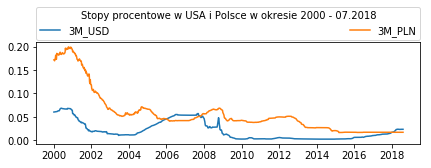

In [13]:
plt.subplot(211)
plt.plot(df[okres+'_'+baz+'_BOR'], label= okres+'_'+baz)
plt.plot(df[okres+'_'+kw+'_BOR'], label = okres+'_'+kw)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=8,
           ncol=2, mode="expand", borderaxespad=0., title = 'Stopy procentowe w USA i Polsce w okresie 2000 - 07.2018')
plt.tight_layout()

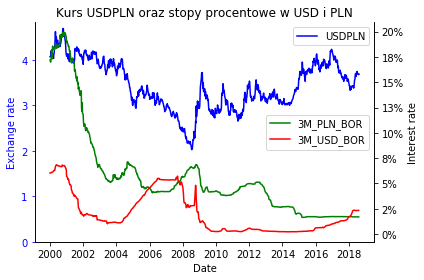

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(df[baz+kw], 'b-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Exchange rate', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(0)
plt.legend()
ax2 = ax1.twinx()
ax2.plot(df[okres+'_'+kw+'_BOR'],'g-')
ax2.plot(df[okres+'_'+baz+'_BOR'],'r-')
ax2.set_ylabel('Interest rate', color='k')
ax2.tick_params('y', colors='k')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.legend(loc=5)
sns.despine(top=True, right=False)
plt.title('Kurs '+baz+kw+' oraz stopy procentowe w '+baz +' i '+kw)
fig.tight_layout()
plt.show()

In [15]:
if okres =='1M':
    shift_steps = 4
elif okres =='3M':
    shift_steps = 13
elif okres =='6M':
    shift_steps = 26
elif okres =='12M':
    shift_steps = 52
if okres =='1M':
    divisioner = 12
elif okres =='3M':
    divisioner = 4
elif okres =='6M':
    divisioner = 2
elif okres =='12M':
    divisioner = 1

In [16]:
df = df[:'2018-08-03']

In [17]:
test_size = 210

# OLS

Zaczynamy od przygotowania danych do badania metodą najmniejszych kwadratów. Nasze dane muszą spełniać wymogi stacjonarności, zatem obliczamy pierwszą różnicę logarytmów naturalnych poszczególnych obserwacji. Okres, dla tego badania to 3 miesiące, a dane są tygodniowe, więc obliczamy różnicę wg zasady: obserwacja w okresie (t+13) minus obserwacja w okresie (t) jest stopą zwrotu z kursu za ten okres.

Różnica pomiędzy stopami procentowymi: stopy WIBOR i LIBOR. Wg. wzoru:

\begin{equation*}
ln \left(1 + i_k \right) - ln \left(1 + i_b \right)
\end{equation*}

gdzie ik to stopa waluty kwotowanej, a ib to stopa waluty bazowej.

In [18]:
df_ols = pd.DataFrame()

In [19]:
df_ols['log_ret'] = np.log(df['USDPLN']) - np.log(df['USDPLN']).shift(-shift_steps)

In [20]:
df_ols['st_'+kw+'-'+'st_'+baz] = np.log(1 + df[okres+'_'+kw+'_BOR']/divisioner) - np.log(1 + df[okres+'_'+baz+'_BOR']/divisioner)

In [21]:
df_ols

,log_ret,st_PLN-st_USD
Data,,
2000-01-07,-0.018260,0.027115
2000-01-14,-0.040920,0.026850
2000-01-21,-0.052644,0.026611
2000-01-28,-0.062376,0.027380
2000-02-04,-0.101280,0.027758
2000-02-11,-0.075363,0.029370
2000-02-18,-0.092631,0.027780
2000-02-25,-0.080228,0.027227
2000-03-03,-0.049773,0.030195


In [22]:
last = df_ols['log_ret'].last_valid_index()

In [23]:
df_ols = df_ols[:last]

In [24]:
df_ols.shape

(957, 2)

In [25]:
ols_train = df_ols[:-test_size]
ols_test = df_ols[-test_size:]

In [26]:
ols_test

,log_ret,st_PLN-st_USD
Data,,
2014-05-02,-0.028313,0.006220
2014-05-09,-0.028928,0.006217
2014-05-16,-0.025831,0.006206
2014-05-23,-0.037193,0.006204
2014-05-30,-0.054177,0.006209
2014-06-06,-0.072024,0.006129
2014-06-13,-0.065371,0.006098
2014-06-20,-0.060158,0.006101
2014-06-27,-0.079451,0.006091


In [27]:
import statsmodels.api as sm

In [28]:
X = ols_train['st_'+kw+'-st_'+baz]

In [29]:
X = sm.add_constant(X)

In [30]:
model = sm.OLS(ols_train['log_ret'], X)

In [31]:
res = model.fit()

Pamiętamy o tym, że z racji tego, że obserwacje na siebie nachodzą (dane tygodniowe, a bierzemy pod uwagę 13 tygodni, tzw. overlap), należy zastosować inną niż standardowa, technikę kalkulacji błędów standardowych. Stosujemy statystykę odpornościową z błedami Newey-Westa.

In [32]:
res_nw = res.get_robustcov_results(cov_type='HAC',maxlags=1)

In [33]:
res_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.262
Date:                Sat, 01 Sep 2018   Prob (F-statistic):             0.0126
Time:                        18:35:35   Log-Likelihood:                 880.98
No. Observations:                 747   AIC:                            -1758.
Df Residuals:                     745   BIC:                            -1749.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0136      0.005      2.700      0.007       0.004       0.023
st_PLN-st_USD    -0.7626      0.305     -2.502      0.013      -1.361      -0.164
==============================================================================
Omnibus:                      170.095   Durbin-Watson:                   0.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.155
Skew:                          -1.163   Prob(JB):                     7.17e-96
Kurtosis:                       5.943   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [34]:
params = res_nw.params
errors = res_nw.bse
r = res_nw.rsquared
nobs = res_nw.nobs
no_resid = res_nw.df_resid
a_tval = abs(res_nw.tvalues[0])
alpha = params[0]
beta = params[1]
b_test = abs((1-beta)/errors[1])
t_0_1 = t.ppf(1-0.05, no_resid)
t_0_05 = t.ppf(1-0.025, no_resid)
t_0_01 = t.ppf(1-0.005, no_resid)
if b_test <= t_0_1:
    b_ver = 'We cannot reject null'
elif b_test <= t_0_05:
    b_ver = '*'
elif b_test <= t_0_01:
    b_ver = '**'
else:
    b_ver = '***'
if a_tval <= t_0_1:
    a_ver = 'We cannot reject null'
elif a_tval <= t_0_05:
    a_ver = '*'
elif a_tval <= t_0_01:
    a_ver = '**'
else:
    a_ver = '***'

Odrzucamy hipotezę o UIP, zarówno dla współczynnika alfa, jak i beta (odrzucamy go dla obszaru krytycznego nawet <1%).

In [35]:
print('alpha verification: ', a_ver, '\n', 'beta verification: ', b_ver)

alpha verification:  *** 
 beta verification:  ***


Jednak celem tego artykułu nie jest stwierdzenie, czy UIP zachodzi, a wartość opracowanego modelu w celu podejmowania inwestycji na rynku walutowym. Dlatego porównujemy wyniki otrzymane na zbiorze testowym do prawdziwych wartości.

In [36]:
res_nw.predict().shape

(747,)

In [37]:
#predictions = pd.Series(res_nw.predict())

In [38]:
#rng = pd.Series(pd.date_range('2000-01-07', periods=747, freq='W-FRI'))

In [39]:
#pred_w_date = pd.concat([rng, predictions], axis=1)

In [40]:
#pred_w_date.columns = ['Data', 'Predictions']

In [41]:
#pred_w_date =pred_w_date.set_index('Data')

In [42]:
X_test = ols_test['st_'+kw+'-'+'st_'+baz]

In [43]:
X_test = sm.add_constant(X_test)

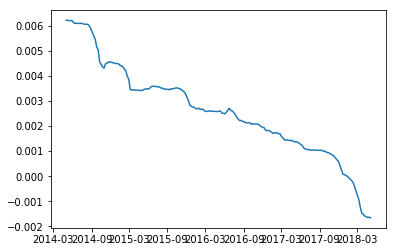

In [44]:
plt.plot(X_test['st_'+kw+'-'+'st_'+baz])

In [45]:
test_pred = res_nw.predict(X_test)

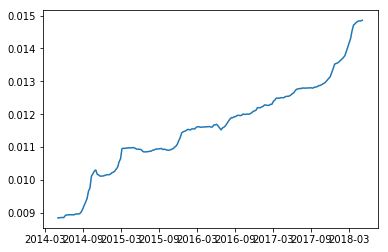

In [46]:
plt.plot(test_pred)

In [47]:
test_true = df[baz+kw][-test_size:]

In [48]:
df_preds_ols = (df[baz+kw][test_pred.index[0]:test_pred.index[-1]]*np.exp(test_pred))

In [49]:
df_preds_ols.index = df_preds_ols.index.shift(shift_steps, freq='W-FRI')

In [50]:
df_preds_ols.head()

Data
2014-08-01    3.056413
2014-08-08    3.066105
2014-08-15    3.084393
2014-08-22    3.072492
2014-08-29    3.059062
Freq: W-FRI, dtype: float64

In [51]:
#rng_test = pd.Series(pd.date_range(test_pred.index[0], periods=test_size, freq='W-FRI'))

In [52]:
#rng_test

In [53]:
df_ols = pd.concat([test_true, df_preds_ols], axis=1)

In [54]:
#df_ols = pd.concat([df_ols, pred_w_date], axis=1)

In [55]:
df_ols.columns = [baz+kw+'_true', baz+kw+'_ols_predicted']

In [56]:
#preds = df[baz+kw] * np.exp(df_ols['Predictions'])

In [57]:
#preds = preds.shift(shift_steps)

Poniższy wykres pokazuje jak radzi sobie model oparty na OLS, w porównaniu do rzeczywistego kursu. Przewidywania przypominają opóźniony wykres cenowy.

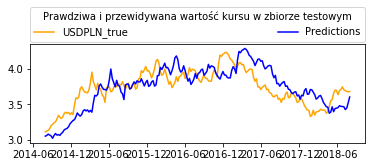

In [58]:
plt.subplot(211)
plt.plot(df_ols[baz+kw+'_true'], color='orange')
plt.plot(df_ols[baz+kw+'_ols_predicted'], color='b', label='Predictions')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., title='Prawdziwa i przewidywana wartość kursu w zbiorze testowym')

In [59]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [60]:
rmse = sqrt(mean_squared_error(y_true=df_ols[baz+kw+'_true'], y_pred=df_ols[baz+kw+'_ols_predicted']))

Jako miarę dopasowania modelu do realnych danych stosujemy RMSE (Root Mean Square Error). Model OLS myli się średnio o ok. 0.2.

In [61]:
rmse

0.20242216083102507

# Neural Network

Poprzez kalkulacje modelu metodą OLS, uzyskaliśmy pewne odniesienie, do którego musimy się odnieść tworząc naszą sztuczną inteligencję. Celem jest stworzenie lepszego dopasowania niż modelu UIP, co powinno skutkować też lepszymi sygnałami kupna i sprzedaży dla naszej strategii.

Używamy technik uczenia głębokiego (Deep Learning), na rekurencyjnych sieciach neuronowych. Bardzo dużą popularnością w tego typu badaniach cieszą się komórki LSTM (Long-Short Term Memory), jednak ja zdecydowałem się zastosować komórki GRU (Gated Recurrent Unit), które są prostsze w konstrukcji i tym samym kalkulacje zajmują mniej czasu i mocy obliczeniowej. W artykule docelowo należy opisać dlaczego wybór padł na ten typ komórek. 

Kolejnym oryginalnym pomysłem, jest zastosowanie w pewnym stopniu feature engineering. Założeniem całego artykułu jest stworzenie modelu opartego jedynie na stopach procentowych i kursie walutowym, w celu stworzenia dochodowej strategii inwestycyjnej, dlatego jako input modelu są jedynie opóźnione (lagged) wartości stóp procentowych oraz kursu. Co jednak zostało dodane to pewna obróbka tych danych. Zastosowałem, EEMD (Ensemble Empirical Mode Decomposition) (chyba polska nazwa nie istnieje) do rozbicia dwóch zmiennych na więcej szeregów czasowych w celu lepszego dopasowania przez model sieci neuronowych.

Tutaj krótki opis tej metody:<br/>
The EEMD consists of the following steps:

1. Adding a white noise series to the original data.
2. Decomposing the data with added white noise into oscillatory components.
3. Repeating step 1 and step 2 again and again, but with different white noise series added each time.
4. Obtaining the (ensemble) means of the corresponding intrinsic mode functions of the decomposition as the final result.

In these steps, EEMD uses two properties of white noise:

+ The added white noise leads to relatively even distribution of extrema distribution on all timescales.
+ The dyadic filter bank property provides a control on the periods of oscillations contained in an oscillatory component, significantly reducing the chance of scale mixing in a component. Through ensemble average, the added noise is averaged out.

In [62]:
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [63]:
df_rnn = df[[baz+kw, okres+'_'+baz+'_BOR', okres+'_'+kw+'_BOR']]

In [64]:
df_rnn['X_'+baz+kw] = df_rnn.loc[:,baz+kw]

C:\Users\piotr\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
df_rnn.head()

,USDPLN,3M_USD_BOR,3M_PLN_BOR,X_USDPLN
Data,,,,
2000-01-07,4.070,0.060300,0.1719,4.070
2000-01-14,4.070,0.060400,0.1709,4.070
2000-01-21,4.070,0.060400,0.1699,4.070
2000-01-28,4.195,0.060487,0.1732,4.195
2000-02-04,4.175,0.060900,0.1752,4.175


In [66]:
target = baz+kw

In [67]:
df_target = df[target].shift(-shift_steps)

In [68]:
df_target

Data
2000-01-07    4.14500
2000-01-14    4.24000
2000-01-21    4.29000
2000-01-28    4.46500
2000-02-04    4.62000
2000-02-11    4.47700
2000-02-18    4.51000
2000-02-25    4.49450
2000-03-03    4.32500
2000-03-10    4.42000
2000-03-17    4.41500
2000-03-24    4.43100
2000-03-31    4.35000
2000-04-07    4.31700
2000-04-14    4.32200
2000-04-21    4.29500
2000-04-28    4.34000
2000-05-05    4.37700
2000-05-12    4.34150
2000-05-19    4.29650
2000-05-26    4.36250
2000-06-02    4.36700
2000-06-09    4.42500
2000-06-16    4.48500
2000-06-23    4.55900
2000-06-30    4.52500
2000-07-07    4.55300
2000-07-14    4.68000
2000-07-21    4.69000
2000-07-28    4.67750
               ...   
2018-01-12    3.37791
2018-01-19    3.39756
2018-01-26    3.47081
2018-02-02    3.55085
2018-02-09    3.57033
2018-02-16    3.65554
2018-02-23    3.70080
2018-03-02    3.69182
2018-03-09    3.63572
2018-03-16    3.69226
2018-03-23    3.70855
2018-03-30    3.74564
2018-04-06    3.70649
2018-04-13    3.69177
2018-

In [69]:
y_data = df_target.values[:-shift_steps]

In [70]:
y_data.shape

(957,)

In [71]:
#x_data = df_rnn.iloc[:,1:].values[0:-shift_steps]

In [72]:
#x_data

In [73]:
import PyEMD

In [74]:
eemd = PyEMD.EEMD()

In [75]:
emd = eemd.EMD

In [76]:
emd.extrema_detection='parabol'

In [77]:
df_rnn['dif'] = df_rnn[okres+'_'+kw+'_BOR'] - df_rnn[okres+'_'+baz+'_BOR']

In [78]:
shifted_rate = df_rnn['X_'+baz+kw].values[:-shift_steps]

In [79]:
shifted_baz = df_rnn[okres+'_'+baz+'_BOR'].values[:-shift_steps]

In [80]:
shifted_kw = df_rnn[okres+'_'+kw+'_BOR'].values[:-shift_steps]

In [81]:
shifted_dif = df_rnn['dif'].values[:-shift_steps]

In [82]:
#tt = df_rnn['X_'+baz+kw][:-shift_steps]

In [83]:
drng = pd.Series(pd.date_range('2014-08-01', periods=210, freq='W-FRI'))

In [84]:
shifted_rate[-210:].shape

(210,)

In [85]:
drng.shape

(210,)

In [86]:
eIMFs = eemd.eemd(shifted_rate)

In [87]:
nIMFs = eIMFs.shape[0]

Tak wygląda notowanie kursu rozbite na poszczególne funkcje IMF przez EEMD. Pierwszy wykres od góry to wykres cenowy. Oryginalnie posiadaliśmy jedną zmienną kursu, a po dekompozycji mamy ich 10.

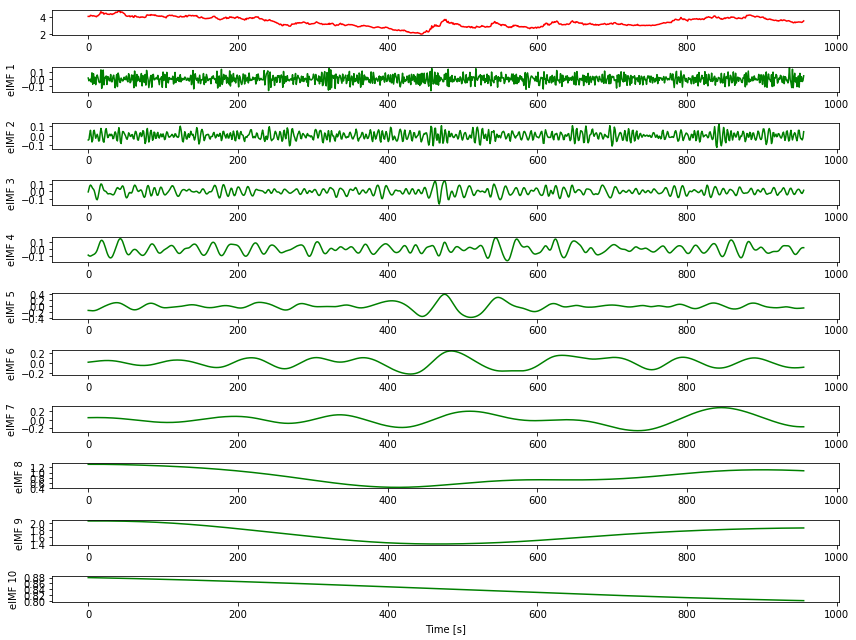

In [88]:
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(shifted_rate, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()

In [89]:
eIMFs.shape

(10, 957)

In [90]:
#pd.DataFrame(eIMFs.transpose()).to_csv('imf_kurs.csv')

In [91]:
'''
imf_baz = eemd.eemd(shifted_baz)
n_imf_baz = imf_baz.shape[0]
'''

'\nimf_baz = eemd.eemd(shifted_baz)\nn_imf_baz = imf_baz.shape[0]\n'

In [92]:
'''
imf_kw = eemd.eemd(shifted_kw)
n_imf_kw = imf_kw.shape[0]
'''

'\nimf_kw = eemd.eemd(shifted_kw)\nn_imf_kw = imf_kw.shape[0]\n'

In [93]:
'''
plt.figure(figsize=(12,9))
plt.subplot(n_imf_baz+1, 1, 1)
plt.plot(shifted_baz, 'r')

for n in range(n_imf_baz):
    plt.subplot(n_imf_baz+1, 1, n+2)
    plt.plot(imf_baz[n], 'g')
    plt.ylabel("imf_baz %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()
'''

'\nplt.figure(figsize=(12,9))\nplt.subplot(n_imf_baz+1, 1, 1)\nplt.plot(shifted_baz, \'r\')\n\nfor n in range(n_imf_baz):\n    plt.subplot(n_imf_baz+1, 1, n+2)\n    plt.plot(imf_baz[n], \'g\')\n    plt.ylabel("imf_baz %i" %(n+1))\n    plt.locator_params(axis=\'y\', nbins=5)\n\nplt.xlabel("Time [s]")\nplt.tight_layout()\n#plt.savefig(\'eemd_example\', dpi=120)\nplt.show()\n'

In [94]:
'''
plt.figure(figsize=(12,9))
plt.subplot(n_imf_kw+1, 1, 1)
plt.plot(shifted_kw, 'r')

for n in range(n_imf_kw):
    plt.subplot(n_imf_kw+1, 1, n+2)
    plt.plot(imf_kw[n], 'g')
    plt.ylabel("imf_kw %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()
'''

'\nplt.figure(figsize=(12,9))\nplt.subplot(n_imf_kw+1, 1, 1)\nplt.plot(shifted_kw, \'r\')\n\nfor n in range(n_imf_kw):\n    plt.subplot(n_imf_kw+1, 1, n+2)\n    plt.plot(imf_kw[n], \'g\')\n    plt.ylabel("imf_kw %i" %(n+1))\n    plt.locator_params(axis=\'y\', nbins=5)\n\nplt.xlabel("Time [s]")\nplt.tight_layout()\n#plt.savefig(\'eemd_example\', dpi=120)\nplt.show()\n'

In [95]:
imf_dif = eemd.eemd(shifted_dif)
n_imf_dif = imf_dif.shape[0]

Drugą zmienną, którą postanowiłem rozdzielić metodą EEMD jest różnica pomiędzy stopami procentowymi w dwóch krajach uzyskana po prostu poprzez odjęcie od siebie tych stóp dla każdego okresu. Podobnie, z jednej zmiennej uzyskaliśmy 8. Zatem łącznie nasza sieć neuronowa otrzyma 18 szeregów czasowych.

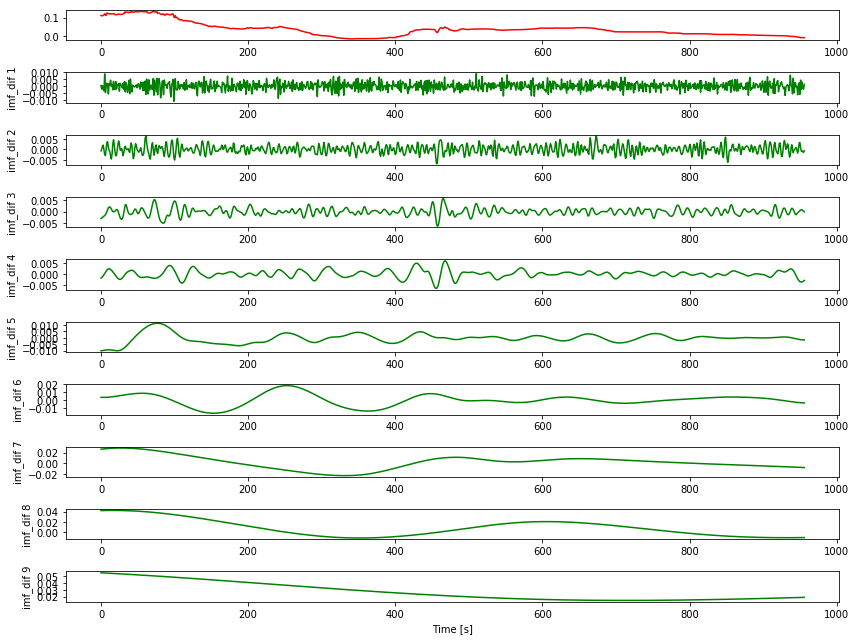

In [96]:
plt.figure(figsize=(12,9))
plt.subplot(n_imf_dif+1, 1, 1)
plt.plot(shifted_dif, 'r')

for n in range(n_imf_dif):
    plt.subplot(n_imf_dif+1, 1, n+2)
    plt.plot(imf_dif[n], 'g')
    plt.ylabel("imf_dif %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
#plt.savefig('eemd_example', dpi=120)
plt.show()

In [97]:
#pd.DataFrame(imf_dif.transpose()).to_csv('imf_dif.csv')

In [158]:
#eIMFs = pd.read_csv('imf_kurs.csv', index_col=0)

In [193]:
#imf_dif = pd.read_csv('imf_dif.csv', index_col = 0)

In [194]:
imf_dif

,0,1,2,3,4,5,6,7
0,0.000678,0.000957,-0.004268,-0.002108,-0.003828,-0.003552,0.033748,0.089662
1,0.000292,0.002332,-0.004787,-0.002164,-0.003976,-0.003565,0.033991,0.089545
2,-0.005576,0.003647,-0.004543,-0.002090,-0.004102,-0.003563,0.034226,0.089428
3,0.003417,0.002683,-0.003437,-0.001890,-0.004206,-0.003545,0.034452,0.089311
4,0.005034,-0.001362,-0.001607,-0.001592,-0.004290,-0.003511,0.034670,0.089193
5,-0.000908,-0.005792,0.000506,-0.001222,-0.004356,-0.003462,0.034880,0.089075
6,-0.000157,-0.006693,0.002423,-0.000807,-0.004404,-0.003396,0.035081,0.088956
7,-0.006931,-0.002001,0.003771,-0.000374,-0.004438,-0.003313,0.035275,0.088838
8,-0.002133,0.004145,0.004325,0.000049,-0.004458,-0.003214,0.035459,0.088718
9,0.007896,0.005948,0.003885,0.000440,-0.004465,-0.003098,0.035635,0.088599


In [195]:
#df_rnn[[okres+'_'+baz+'_BOR', okres+'_'+kw+'_BOR']].values[:-shift_steps].shape

In [275]:
x_data = np.concatenate((imf_dif, eIMFs), axis=1)

In [276]:
#x_data = imf_dif.transpose()

In [277]:
x_data.shape

(957, 18)

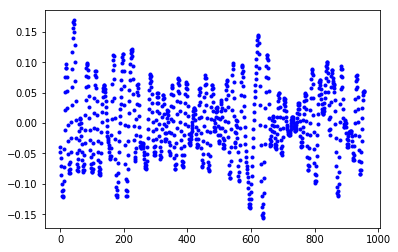

In [278]:
plt.plot(x_data[0:,11],'b.')

In [279]:
x_train = x_data[:-210]
x_test = x_data[-210:]

In [280]:
y_train = y_data[:-210]
y_test = y_data[-210:]

In [281]:
num_train = len(x_train)

In [282]:
num_x_signals = x_data.shape[1]

In [283]:
num_y_signals = 1

In [284]:
x_scaler = MinMaxScaler()

In [285]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [286]:
x_test_scaled = x_scaler.transform(x_test)

In [287]:
x_train_scaled

array([[0.53918584, 0.60568939, 0.08665221, ..., 0.97882341, 0.98938297,
        1.        ],
       [0.51453595, 0.69330739, 0.0395839 , ..., 0.97886534, 0.99013428,
        0.99926239],
       [0.13986879, 0.77705439, 0.06173644, ..., 0.97892029, 0.99085892,
        0.99852147],
       ...,
       [0.40386237, 0.41182344, 0.38300994, ..., 0.35411258, 0.56085938,
        0.00262632],
       [0.53906219, 0.47303352, 0.37729358, ..., 0.357171  , 0.56343235,
        0.00131227],
       [0.26929151, 0.4971526 , 0.3799674 , ..., 0.36029836, 0.566001  ,
        0.        ]])

In [288]:
y_scaler = MinMaxScaler()

In [289]:
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))

In [290]:
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

In [291]:
x_test_scaled.shape

(210, 18)

In [292]:
y_test_scaled.shape

(210, 1)

In [293]:
def batch_generator(batch_size, sequence_length):
    while True:
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [294]:
batch_size = 16

In [295]:
sequence_length = 16

In [296]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [297]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [298]:
path_checkpoint = 'checkpoint_art_c.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [299]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [300]:
callback_tensorboard = TensorBoard(log_dir='./logs/'+baz+kw+'8',
                                   histogram_freq=0,
                                   write_graph=True)

In [301]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

In [302]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [303]:
model = Sequential()

model.add(GRU(units = 512, return_sequences=True, activation='tanh', input_shape=(None, num_x_signals,), name='GRU_layer'))
    
model.add(GRU(units = 256, return_sequences=True, activation='tanh', name='hidden_GRU_layer_1'))

model.add(GRU(units = 256, return_sequences=True, activation='tanh', name='hidden_GRU_layer_2'))

model.add(GRU(units = 256, return_sequences=True, activation='tanh', name='hidden_GRU_layer_3'))

#model.add(GRU(units = 512, return_sequences=True, activation='tanh', name='hidden_GRU_layer_4'))

#model.add(GRU(units = 512, return_sequences=True, activation='relu', name='hidden_GRU_layer_5'))

model.add(Dense(num_y_signals, activation='linear'))
    
optimizer = Adam(lr=0.001)
    
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

Podsumowanie konstrukcji sieci neuronowej. Na podstawie wieeelu testów z takim układem uzyskałem najlepsze wyniki. Jest zatem pierwsza warstwa oczekująca konkretnej ilości inputs, posiadająca 512 jednostek GRU. 3 ukryte warstwy również GRU po 256 jednostek. Oraz ostatnia warstwa dająca output = 1, czyli przewidywania modelu.

In [304]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_layer (GRU)              (None, None, 512)         815616    
_________________________________________________________________
hidden_GRU_layer_1 (GRU)     (None, None, 256)         590592    
_________________________________________________________________
hidden_GRU_layer_2 (GRU)     (None, None, 256)         393984    
_________________________________________________________________
hidden_GRU_layer_3 (GRU)     (None, None, 256)         393984    
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           257       
Total params: 2,194,433
Trainable params: 2,194,433
Non-trainable params: 0
_________________________________________________________________


Następnie model jest trenowany tak żeby najlepiej dopasować się do danych. Po 10 epokach trening został zaprzestany, ponieważ nie poczynił postępów przez 5 kolejnych epok.

In [305]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=18,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
17/18 [===========================>..] - ETA: 3s - loss: 0.0852 - mean_squared_error: 0.0852 - mean_absolute_error: 0.2161
Epoch 00001: val_loss improved from inf to 0.05759, saving model to checkpoint_art_c.keras
18/18 [==============================] - 63s 4s/step - loss: 0.0821 - mean_squared_error: 0.0821 - mean_absolute_error: 0.2112 - val_loss: 0.0576 - val_mean_squared_error: 0.0576 - val_mean_absolute_error: 0.2330
Epoch 2/20
17/18 [===========================>..] - ETA: 1s - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0896
Epoch 00002: val_loss improved from 0.05759 to 0.01590, saving model to checkpoint_art_c.keras
18/18 [==============================] - 26s 1s/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0892 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1157
Epoch 3/20
17/18 [===========================>..] - ETA: 1s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_

In [306]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [307]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 2s 2s/step


In [308]:
for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

loss: 4.051e-03
mean_squared_error: 4.051e-03
mean_absolute_error: 5.255e-02


In [309]:
y_pred = model.predict(np.expand_dims(x_test_scaled, axis=0), 16)

In [310]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

Poniżej znajduje się graf pochodzący z tensorboard, na którym świetnie widać dokładnie co dzieje się w trakcie treningu modelu. Rysunek jest interaktywny i mam nadzieje, że na GitHub taki pozostanie.

In [136]:
show_graph(tf.get_default_graph().as_graph_def())

In [311]:
y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1,1))

In [312]:
shifted_baz_bid = df[okres+'_'+baz+'_BID'].values[:-shift_steps]

In [313]:
shifted_kw_bid = df[okres+'_'+kw+'_BID'].values[:-shift_steps]

In [314]:
df_final = pd.concat([drng, pd.DataFrame(y_test), pd.DataFrame(y_pred_rescaled), pd.Series(df_ols[baz+kw+'_ols_predicted'].values), pd.Series(shifted_rate[-210:]), pd.Series(shifted_baz[-210:]), pd.Series(shifted_kw[-210:]), pd.Series(shifted_baz_bid[-210:]), pd.Series(shifted_kw_bid[-210:])], axis=1)

df_final.columns = ['Data', baz+kw+'_true', baz+kw+'_predicted_rnn', baz+kw+'_predicted_ols', baz+kw+'_shifted', okres+'_'+baz+'_BOR', okres+'_'+kw+'_BOR', okres+'_'+baz+'_BID', okres+'_'+kw+'_BID']

df_final = df_final.set_index('Data')

In [315]:
df_final.head()

,USDPLN_true,USDPLN_predicted_rnn,USDPLN_predicted_ols,USDPLN_shifted,3M_USD_BOR,3M_PLN_BOR,3M_USD_BID,3M_PLN_BID
Data,,,,,,,,
2014-08-01,3.1165,2.801736,3.056413,3.0295,0.002229,0.0272,0.0002,0.0252
2014-08-08,3.1283,3.110079,3.066105,3.0391,0.002241,0.0272,0.0003,0.0252
2014-08-15,3.1372,3.117578,3.084393,3.0572,0.002286,0.0272,0.0003,0.0252
2014-08-22,3.1608,3.028893,3.072492,3.0454,0.002293,0.0272,0.0004,0.0252
2014-08-29,3.2009,3.021513,3.059062,3.0321,0.002274,0.0272,0.0004,0.0252


In [316]:
df_final['AI_carry'] = np.where(df_final[baz+kw+'_predicted_rnn']>=df_final[baz+kw+'_shifted'], ((1+df_final[okres+'_'+baz+'_BID']/divisioner)*(1/df_final[baz+kw+'_shifted']))/(1/df_final[baz+kw+'_true'])-(1+df_final[okres+'_'+kw+'_BOR']/divisioner), ((1+df_final[okres+'_'+kw+'_BID']/divisioner)*df_final[baz+kw+'_shifted'])/(df_final[baz+kw+'_true'])-(1+df_final[okres+'_'+baz+'_BOR']/divisioner))

In [317]:
df_final['Classic_carry'] = np.where(df_final[okres+'_'+baz+'_BOR']>=df_final[okres+'_'+kw+'_BOR'], ((1+df_final[okres+'_'+baz+'_BID']/divisioner)*(1/df_final[baz+kw+'_shifted']))/(1/df_final[baz+kw+'_true'])-(1+df_final[okres+'_'+kw+'_BOR']/divisioner), ((1+df_final[okres+'_'+kw+'_BID']/divisioner)*df_final[baz+kw+'_shifted'])/(df_final[baz+kw+'_true'])-(1+df_final[okres+'_'+baz+'_BOR']/divisioner))

In [318]:
df_final['OLS_carry'] = np.where(df_final[baz+kw+'_predicted_ols']>=df_final[baz+kw+'_shifted'], ((1+df_final[okres+'_'+baz+'_BID']/divisioner)*(1/df_final[baz+kw+'_shifted']))/(1/df_final[baz+kw+'_true'])-(1+df_final[okres+'_'+kw+'_BOR']/divisioner), ((1+df_final[okres+'_'+kw+'_BID']/divisioner)*df_final[baz+kw+'_shifted'])/(df_final[baz+kw+'_true'])-(1+df_final[okres+'_'+baz+'_BOR']/divisioner))

# Wnioski

Konstruujemy finałową tabelę, w której znajduje się wszystko do tej pory obliczone. W tej tabeli kalkulujemy też wyniki dla klasycznej strategii Carry Trade - decyzji podejmowanych jedynie na podstawie różnicy w stopie procentowej.

In [319]:
df_final

,USDPLN_true,USDPLN_predicted_rnn,USDPLN_predicted_ols,USDPLN_shifted,3M_USD_BOR,3M_PLN_BOR,3M_USD_BID,3M_PLN_BID,AI_carry,Classic_carry,OLS_carry
Data,,,,,,,,,,,
2014-08-01,3.11650,2.801736,3.056413,3.02950,0.002229,0.0272,0.0002,0.0252,-0.022349,-0.022349,0.021969
2014-08-08,3.12830,3.110079,3.066105,3.03910,0.002241,0.0272,0.0003,0.0252,0.022628,-0.022954,0.022628
2014-08-15,3.13720,3.117578,3.084393,3.05720,0.002286,0.0272,0.0003,0.0252,0.019445,-0.019933,0.019445
2014-08-22,3.16080,3.028893,3.072492,3.04540,0.002293,0.0272,0.0004,0.0252,-0.031013,-0.031013,0.031197
2014-08-29,3.20090,3.021513,3.059062,3.03210,0.002274,0.0272,0.0004,0.0252,-0.047336,-0.047336,0.048977
2014-09-05,3.22340,3.029523,3.026256,2.99940,0.002296,0.0269,0.0004,0.0249,0.068064,-0.064273,0.068064
2014-09-12,3.24430,3.101773,3.066283,3.03900,0.002321,0.0268,0.0004,0.0248,0.060962,-0.058053,0.060962
2014-09-19,3.25600,3.152874,3.093416,3.06590,0.002306,0.0268,0.0002,0.0248,0.055358,-0.053123,0.055358
2014-09-26,3.29550,3.172941,3.071141,3.04380,0.002346,0.0268,0.0003,0.0248,0.076074,-0.071237,0.076074


Wykres pokazuje przewidywania sieci neuronowej i prawdziwą wartość kursu w okresie testowym. Dla naszej strategii ważniejsze niż to czy model dokładnie pokrywa się z realną ceną, jest kierunek, który model przewiduje i po samym spojrzeniu, można zauważyć, że z tym radzi sobie całkiem nieźle.

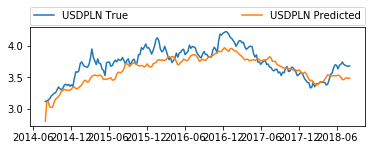

In [320]:
plt.subplot(211)
plt.plot(df_final[baz+kw+'_true'], label=baz+kw+' True')
plt.plot(df_final[baz+kw+'_predicted_rnn'], label = baz+kw+' Predicted')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

In [321]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse_rnn = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_rescaled))

Model sieci neuronowych uzyskał nieco lepszy wynik RMSE - ok. 0.16.

In [322]:
rmse_rnn

0.16952358436503986

In [323]:
df_res = pd.DataFrame()

In [324]:
df_res['AI_cum'] = np.cumsum(df_final['AI_carry'][1:])
df_res['Carry_cum'] = np.cumsum(df_final['Classic_carry'][1:])
df_res['OLS_cum'] = np.cumsum(df_final['OLS_carry'][1:])

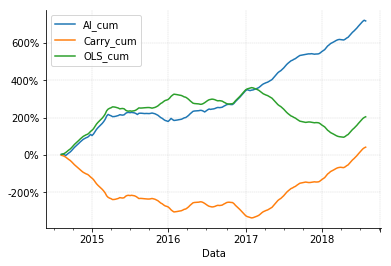

In [325]:
ax = df_res.plot()
ax.grid(linestyle='--', linewidth=0.4, alpha=0.6)
val = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in val])
sns.despine()

Powyższy wykres pokazuje skuteczność trzech strategii, których kalkulacji się podjęliśmy. Wyniki uzyskane to suma zwrotów z inwestycji podejmowanych każdego tygodnia przez cały okres testowy. Kalkulacje biorą pod uwagę stratę na stopie procentowej w przypadku inwestycji odwrotnej do oryginalnego Carry Trade.

'Carry Trade' wsparte AI osiągnęło stopę zwrotu większą niż 700%.

'Carry Trade' oparte na klasycznym modelu regresji Famy UIP osiągnęło ok 200%.

Carry Trade klasyczne osiągnęło rzutem na taśmę wynik pozytywny.